In [1]:
import numpy as np
import matplotlib.pyplot as plt
from numba import cuda
from math import ceil, exp

In [2]:
@cuda.jit
def discreteLogistic(lims,X_0,A,n_iter):
    for i_x, x_0 in enumerate(X_0):
        for i_a, a in enumerate(A):
            lims[i_x,i_a] = a*x_0*(1-x_0)
            for _ in range(1,n_iter):
                lims[i_x,i_a] = a*lims[i_x,i_a]*(1-lims[i_x,i_a])

@cuda.jit
def discreteLogisticExp(lims,X_0,A,n_iter):
    for i_x, x_0 in enumerate(X_0):
        for i_a, a in enumerate(A):
            lims[i_x,i_a] = a*x_0*(1-x_0)
            for _ in range(1,n_iter):
                lims[i_x,i_a] = a*lims[i_x,i_a]*(1-lims[i_x,i_a])
            lims[i_x,i_a] = exp(lims[i_x,i_a])

def getIndices(image, i, j, x, y):
    fi, fj = i /len(y) , j/ len(x)
    ii ,jj = np.ceil(fi*image.shape[0]).astype(int), np.ceil(fj*image.shape[1]).astype(int)
    return ii, jj

def getValueLoc(axisSize, x, x_min,x_max):
    fi = (x - x_min)/(x_max-x_min)
    val = np.ceil(fi*axisSize).astype(int)
    return val if val < axisSize else axisSize - 1 

@cuda.jit    
def fillimage(image,values,x):
    x_min = np.infty
    x_max = -np.infty
    y_min = np.infty
    y_max = -np.infty
    for i,x_i in enumerate(x):
        if x_i < x_min:
            x_min = x_i
        elif x_max < x_i:
            x_max = x_i
    
    for i in range(values.shape[0]):
        for j in range(values.shape[1]):
            if values[i,j] < y_min:
                y_min = values[i,j]
            elif y_max < values[i,j]:
                y_max = values[i,j]
    
    for i in range(len(x)):
        X_dest = int(ceil((x[i] - x_min)/(x_max - x_min)*image.shape[0]))
            
        row_values = values[:,i]
        for j in range(len(row_values)):
            Y_dest = int(ceil((row_values[j] - y_min)/(y_max - y_min)*image.shape[1]))
            if Y_dest >= image.shape[1]:
                Y_dest = image.shape[1] -1 
            if X_dest >= image.shape[0]:
                X_dest = image.shape[0] -1 
            image[Y_dest,X_dest] = 1
            
nA = 1000
nX_0 = 1000
n_iter = 100
A = np.linspace(0.,4.,nA)
X_0 = np.linspace(0.,1.,nX_0)

lims = np.zeros(shape=(nX_0,nA))
limsExp = np.zeros(shape=(nX_0,nA))
discreteLogistic(lims,X_0,A,n_iter)
discreteLogisticExp(limsExp,X_0,A,n_iter)

img_size = 1000
image= np.zeros(shape=(img_size,img_size))
image2= np.zeros(shape=(img_size,img_size))
fillimage(image,lims,A)
fillimage(image2,limsExp,A)

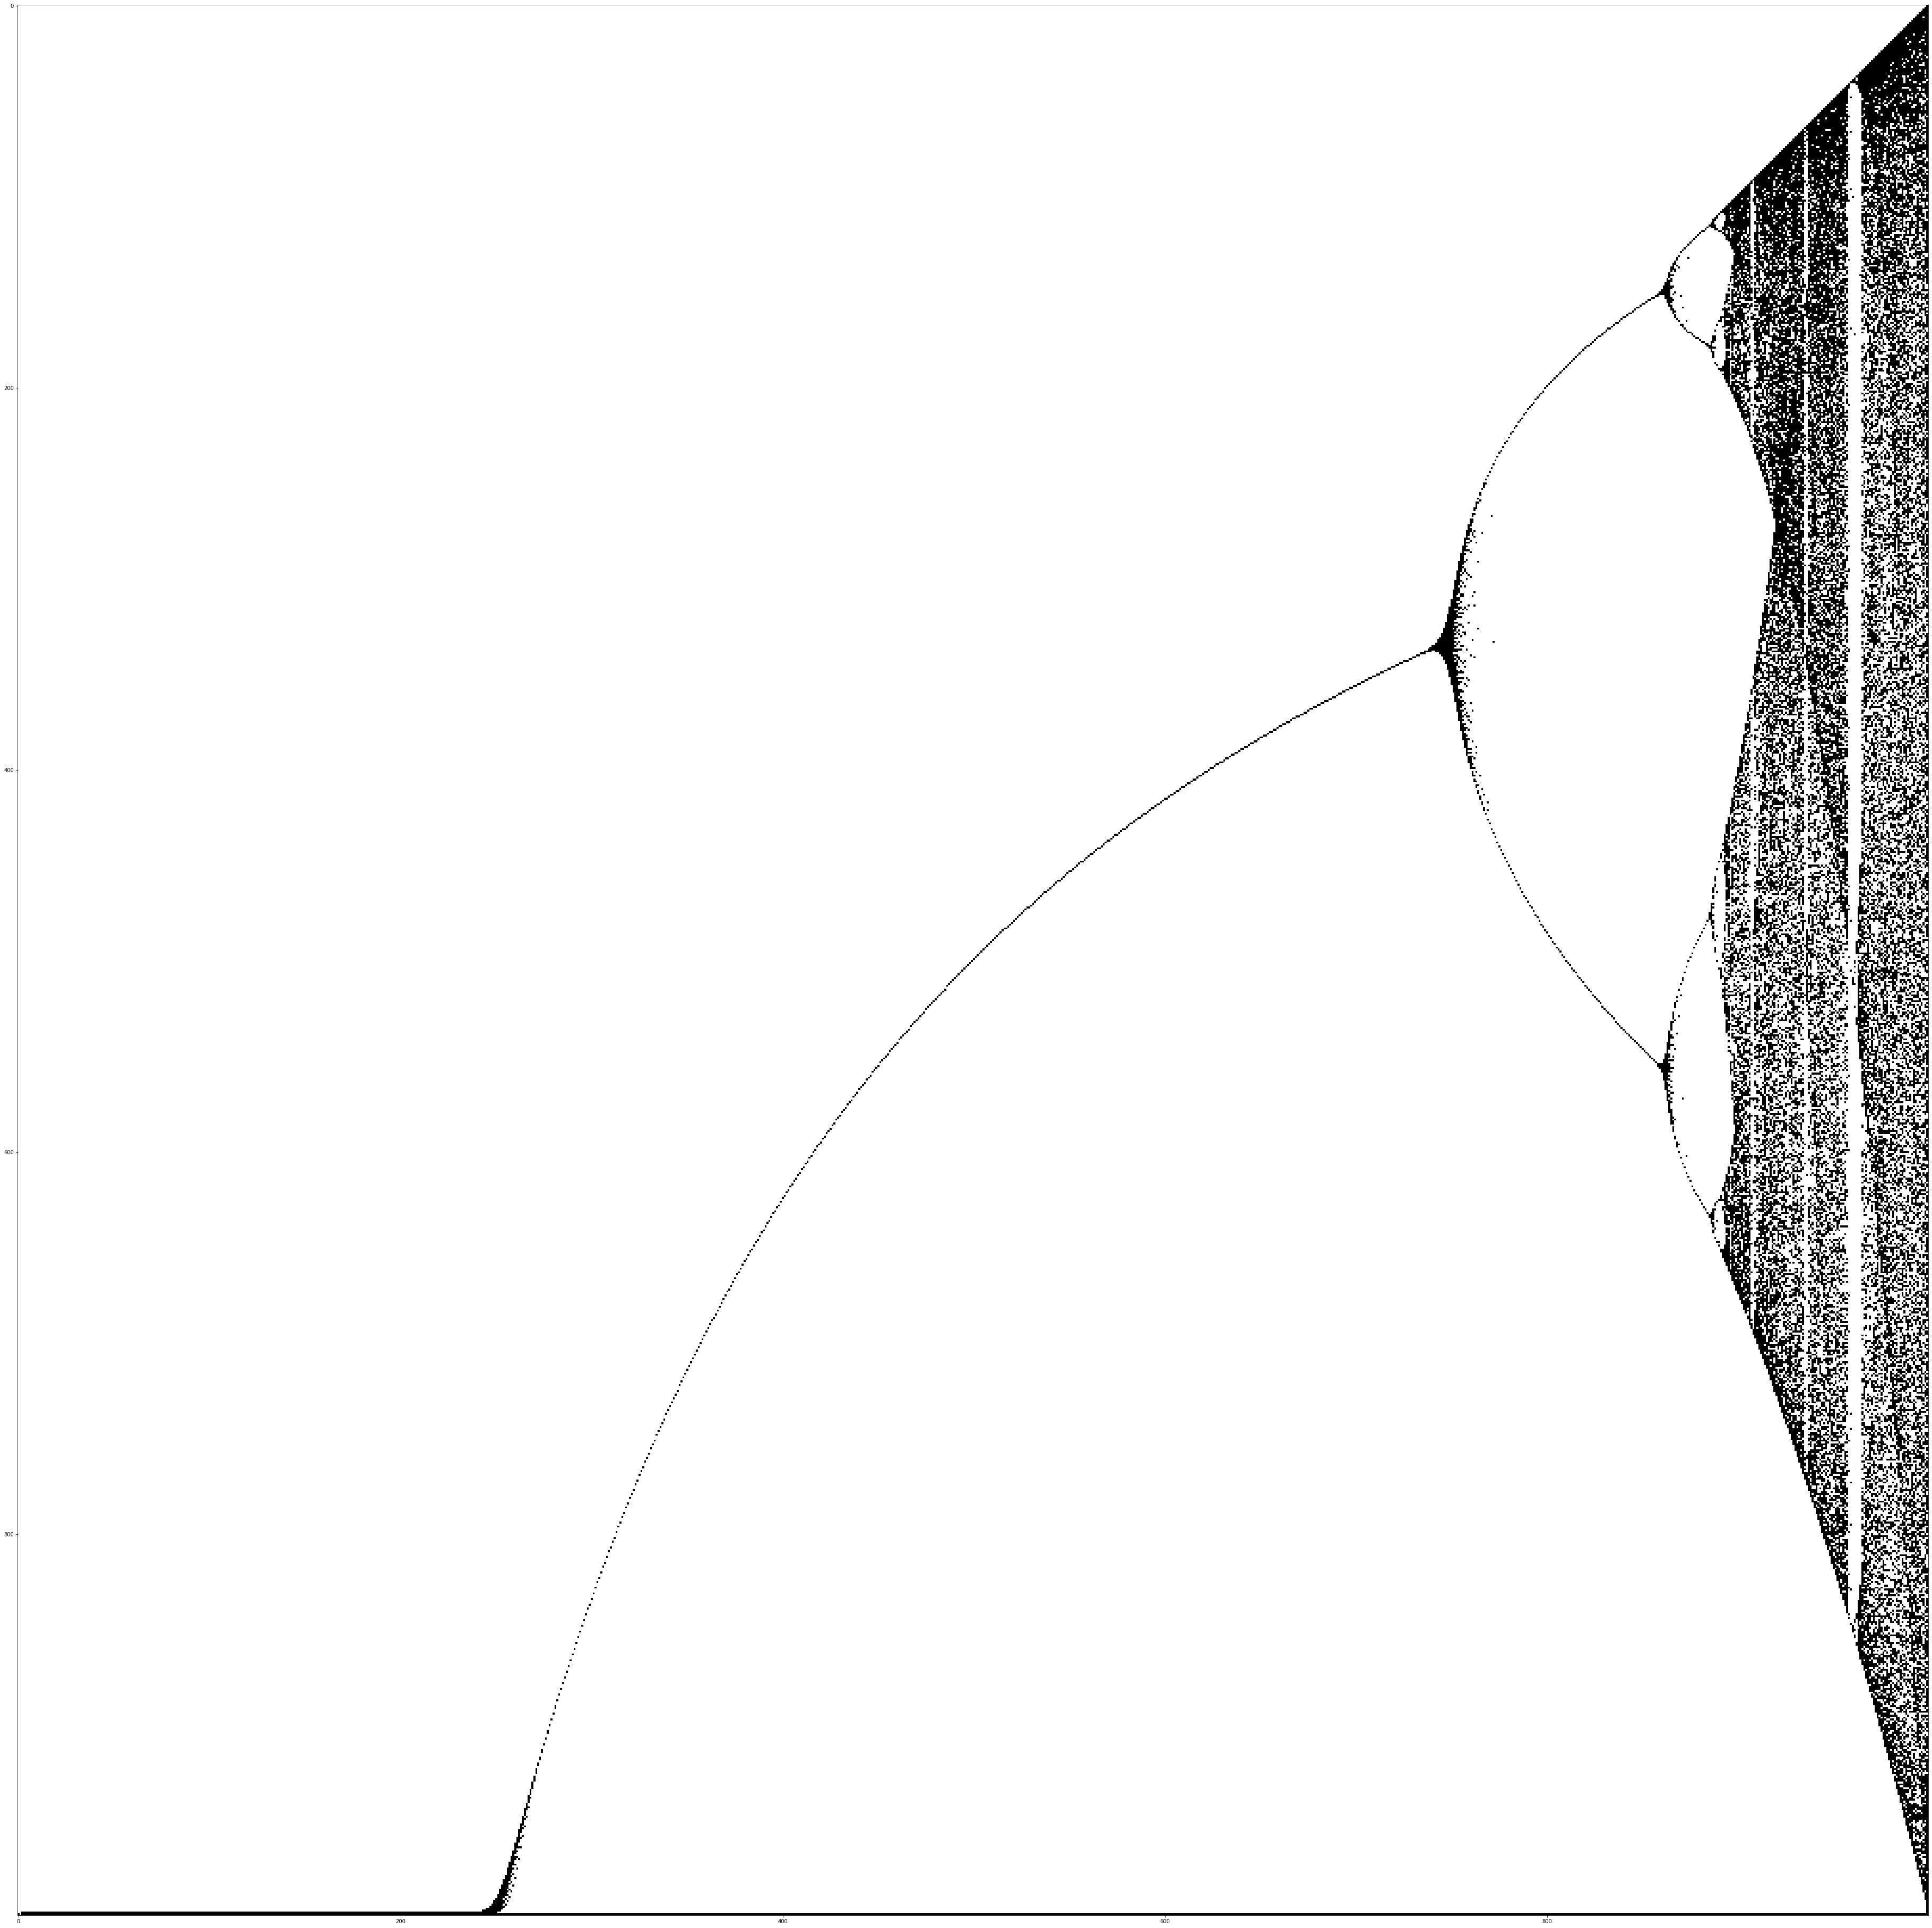

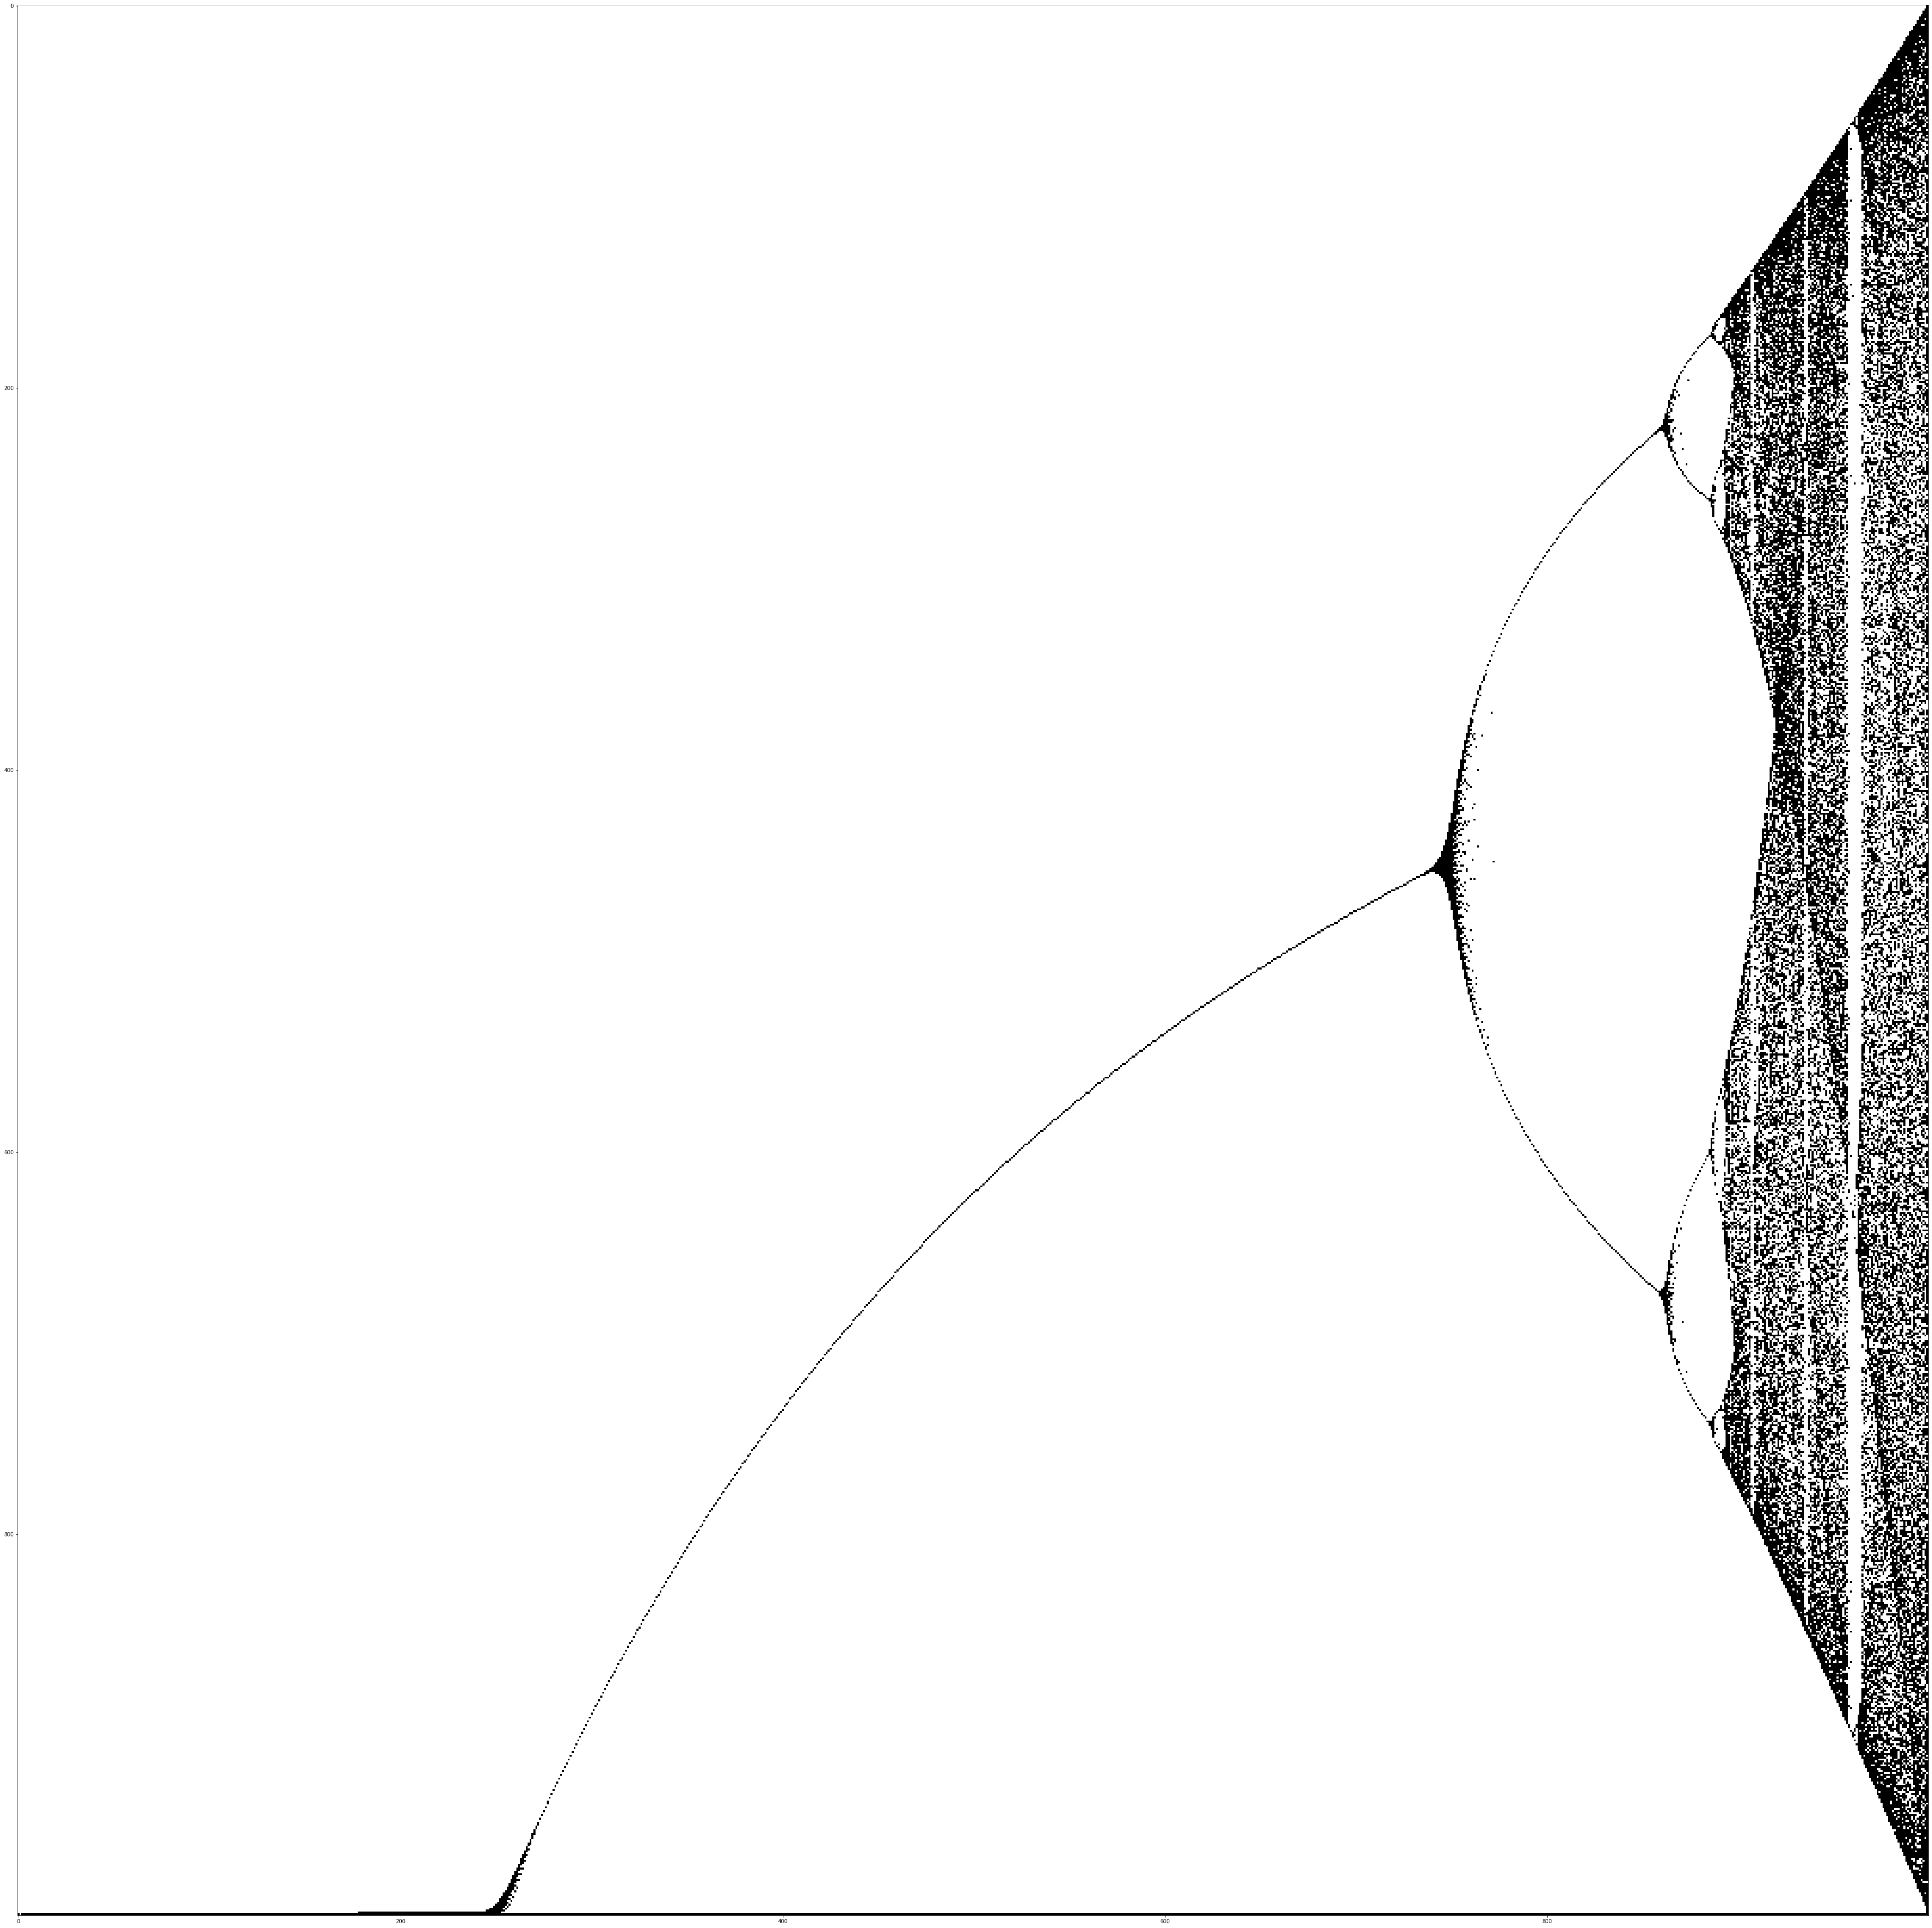

In [3]:
figsize= (100,50)
plt.figure(figsize=figsize)
plt.subplots_adjust(left=0, right=1, top=1, bottom=0)
plt.imshow(1-image[::-1,:],cmap='gray')
plt.savefig('./discrete-logistics.pdf',cmap='gray', ext='pdf')
plt.show()
plt.close()
figsize= (100,50)
plt.figure(figsize=figsize)
plt.subplots_adjust(left=0, right=1, top=1, bottom=0)
plt.imshow(1-image2[::-1,:],cmap='gray')
plt.savefig('./discrete-logistics-2.pdf',cmap='gray', ext='pdf')
plt.show()
plt.close()